In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [4]:
def cosine_distance(A, B):
    P = np.outer(np.sum(A**2, axis=1), np.sum(B**2, axis=1))
    N = np.dot(A, B.T)
    return 1 - N / np.sqrt(P)

In [5]:
def euclidean_distance(a, b):
    P = np.add.outer(np.sum(a**2, axis=1), np.sum(b**2, axis=1))
    N = np.dot(a, b.T)
    return np.sqrt(P - 2*N)

In [6]:
class NearestNeighborsFinder:
    
    def __init__(self, n_neighbors, metric='euclidean'):
        self.n_neighbors = n_neighbors
        if metric == 'euclidean':
            self.metric = euclidean_distance
        elif metric == 'cosine':
            self.metric = cosine_distance
        else:
            raise ValueError("Metric is not supported", metric)
            
    def fit(self, X):
        self._X = X
        
    def kneighbors(self, X, return_distance=False):
        # строки - обьекты из теста
        # столбцы - обьекты из трейна
        ranks = self.metric(X, self._X)
        if self.n_neighbors < ranks.shape[1]:
            ind = np.argpartition(ranks, self.n_neighbors-1, axis=1)[:, :self.n_neighbors]
            dist = np.take_along_axis(ranks, ind, axis=1)
            ind = np.take_along_axis(ind, np.argsort(dist), axis=1)
            if return_distance:
                dist = np.take_along_axis(ranks, ind, axis=1)
        else:
            ind = np.argsort(ranks, axis=1)[:, :self.n_neighbors]
            if return_distance:
                dist = np.take_along_axis(ranks, ind, axis=1)
        if return_distance:
            return dist, ind
        return ind

In [7]:
from sklearn.neighbors import NearestNeighbors

In [8]:
class KNN:
    EPS = 1e-5
    
    def __init__(self, n_neighbors, algorithm='my_own', metric='euclidean', weights='uniform'):
        
        if algorithm == 'my_own':
            finder = NearestNeighborsFinder(n_neighbors=n_neighbors, metric=metric)
        elif algorithm in ('brute', 'ball_tree', 'kd_tree',):
            finder = NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm, metric=metric)
        else:
            raise ValueError("Algorithm is not supported", algorithm)
        
        if weights not in ('uniform', 'distance'):
            raise ValueError("Weighted algorithm is not supported", weights)
        self._finder = finder
        self._weights = weights
        
    
    def fit(self, X, y=None):
        self._finder.fit(X)
        self._labels = np.asarray(y)
        return self
    
    
    def kneighbors(self, X, return_distance=False):
        return self._finder.kneighbors(X, return_distance=return_distance)
    
    
    def predict(self, X):
        distances, indices = self.kneighbors(X, return_distance=True)
        return self._predict_precomputed(indices, distances)
    
    
    def _predict_precomputed(self, indices, distances):
        pass

## Classifier

In [9]:
class KNNClassifier(KNN):
    
    def _predict_precomputed(self, indices, distances):
        y_pred = np.zeros(distances.shape[0])
        if self._weights == 'uniform':
            for i in range(distances.shape[0]):
                y_nearest = self._labels[indices[i]]
                values, counts = np.unique(y_nearest, return_counts=True)
                y_pred[i] = values[np.argmax(counts)]
            return y_pred
        else:
            for i in range(distances.shape[0]):
                y_nearest = self._labels[indices[i]]
                score = dict.fromkeys(np.unique(y_nearest), 0)
                for j in range(distances.shape[1]):
                    score[y_nearest[j]] += 1/(distances[i, j] + self.EPS)
                    y_pred[i] = max(score, key=score.get)
            return y_pred


### Testing

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time

In [11]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

In [12]:
algorithms = ['kd_tree', 'ball_tree', 'brute', 'my_own']

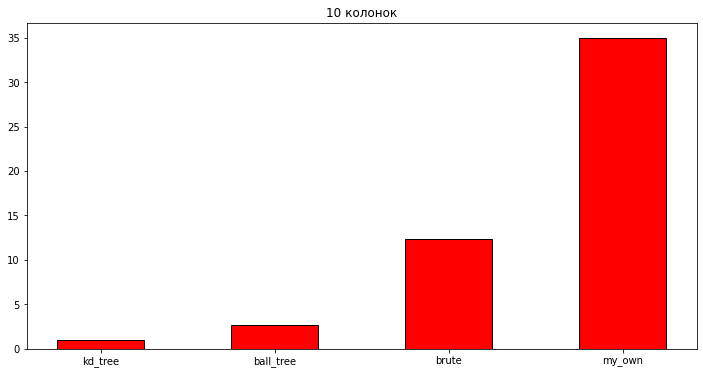

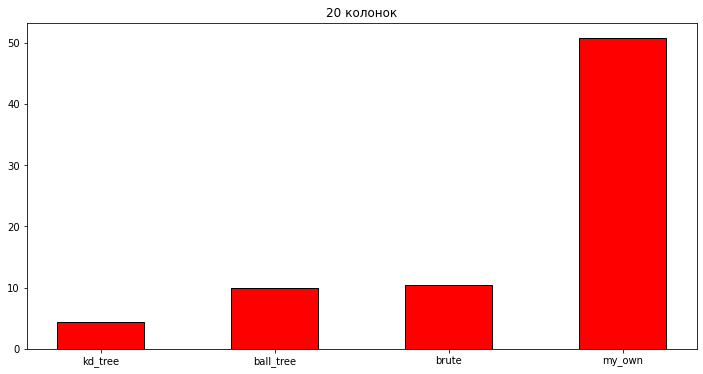

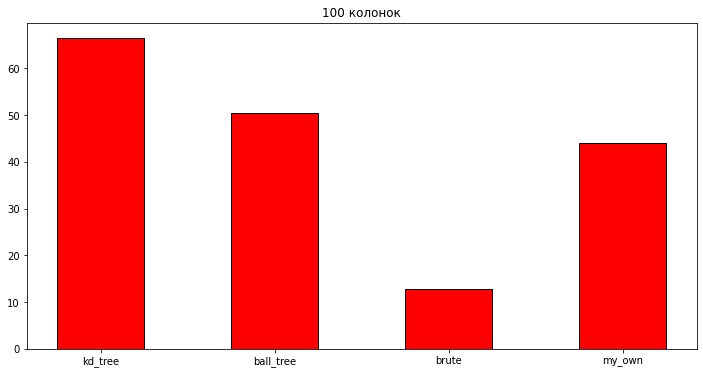

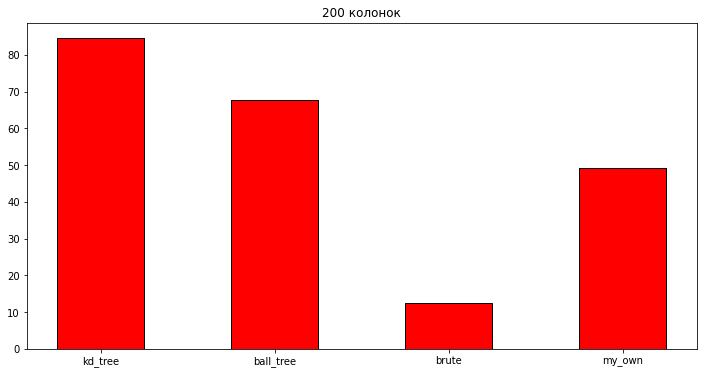

In [13]:
for i in [10, 20, 100, 200]:
    scores = dict()
    cols = sorted(np.random.choice(784, i))
    x = X[:40000, cols]
    x_train, x_test, y_train, y_test = train_test_split(x, y[:40000], random_state=42)
    for algo in algorithms:
        knn = KNNClassifier(n_neighbors=5, algorithm=algo)
        knn.fit(x_train, y_train)
    
        start_time = time.time()
        knn.predict(x_test)
        scores[algo] = time.time() - start_time

    plt.figure(figsize=(12,6))
    plt.bar(scores.keys(), scores.values(), color = 'red', edgecolor = 'black', width=0.5)
    plt.title(str(i) + ' колонок')
    plt.show()

### Breast cancer

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [15]:
X, y = load_breast_cancer().data, load_breast_cancer().target

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
knn = KNNClassifier(n_neighbors=5, algorithm='my_own')
knn.fit(X_train, y_train)
y_preds = knn.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.97      0.97      0.97        89

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



In [19]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_preds = knn.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.97      0.97      0.97        89

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



In [20]:
knn = KNNClassifier(n_neighbors=5, algorithm='my_own', metric='cosine')
knn.fit(X_train, y_train)
y_preds = knn.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        54
           1       0.99      0.96      0.97        89

    accuracy                           0.97       143
   macro avg       0.96      0.97      0.96       143
weighted avg       0.97      0.97      0.97       143



## BatchedKNNClassifier

Нам нужен этот класс, потому что мы хотим поддержку обработки батчами

In [21]:
class BatchedKNNClassifier(KNNClassifier):

    def __init__(self, n_neighbors, algorithm='my_own', metric='euclidean', weights='uniform', batch_size=None):
        KNNClassifier.__init__(
            self,
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            weights=weights,
            metric=metric,
        )
        self._batch_size = batch_size
        
    def kneighbors(self, X, return_distance=False):
        if self._batch_size is None or self._batch_size >= X.shape[0]:
            return super().kneighbors(X, return_distance=return_distance)
        else:
            if return_distance:
                distances = []
                indexes = []
                for i_min in range(0, X.shape[0], self._batch_size):
                    i_max = min(i_min + self._batch_size, X.shape[0])
                    dist, ind = super().kneighbors(X[i_min:i_max], return_distance=return_distance)
                    distances.append(dist)
                    indexes.append(ind)
                return np.vstack(distances), np.vstack(indexes)
            else:
                indexes = []
                for i_min in range(0, X.shape[0], self._batch_size):
                    i_max = min(i_min + self._batch_size, X.shape[0])
                    ind = super().kneighbors(X[i_min:i_max], return_distance=return_distance)
                    indexes.append(ind)
                return np.vstack(indexes)

### Testing

In [22]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

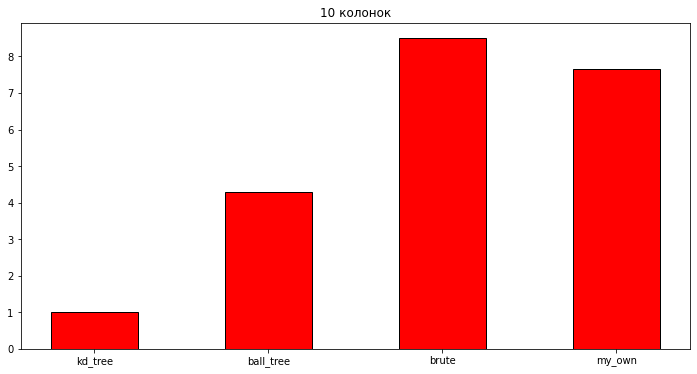

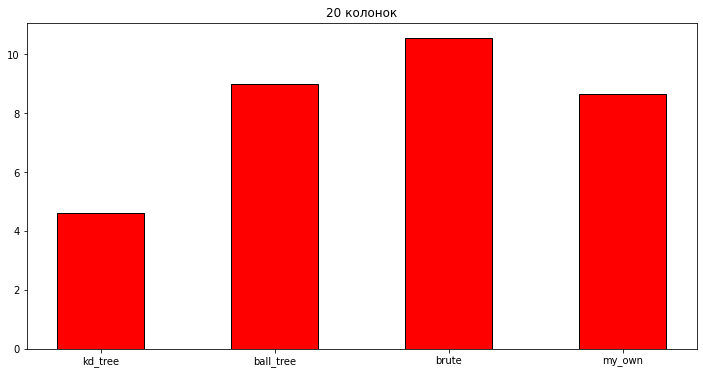

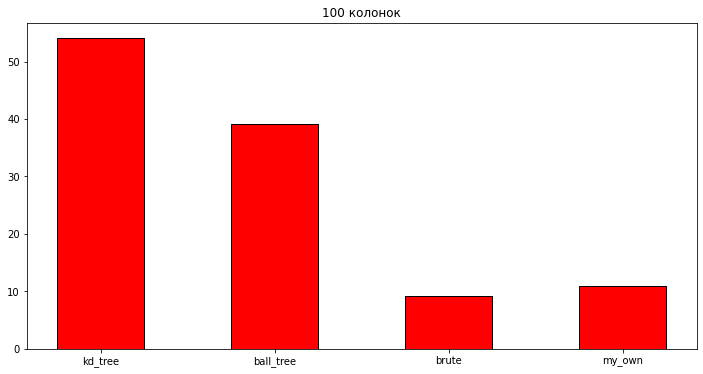

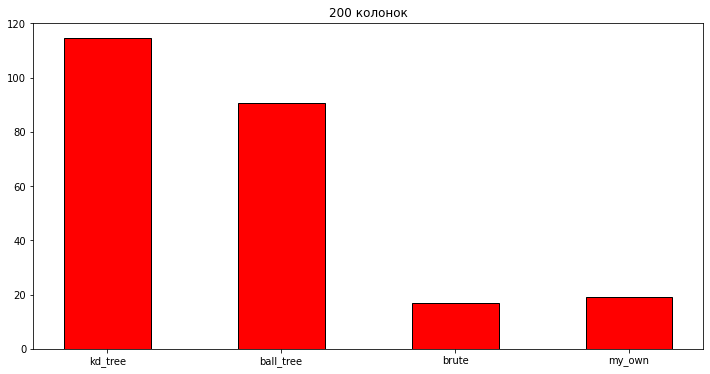

In [23]:
for i in [10, 20, 100, 200]:
    scores = dict()
    cols = sorted(np.random.choice(784, i))
    x = X[:40000, cols]
    x_train, x_test, y_train, y_test = train_test_split(x, y[:40000], random_state=42)
    for algo in algorithms:
        knn = BatchedKNNClassifier(n_neighbors=5, algorithm=algo, batch_size=32)
        knn.fit(x_train, y_train)
    
        start_time = time.time()
        knn.predict(x_test)
        scores[algo] = time.time() - start_time

    plt.figure(figsize=(12,6))
    plt.bar(scores.keys(), scores.values(), color = 'red', edgecolor = 'black', width=0.5)
    plt.title(str(i) + ' колонок')
    plt.show()

### Breast cancer

In [24]:
X, y = load_breast_cancer().data, load_breast_cancer().target

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
knn = BatchedKNNClassifier(n_neighbors=5, algorithm='my_own', batch_size=32)
knn.fit(X_train, y_train)
y_preds = knn.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.97      0.97      0.97        89

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



## Regression

In [28]:
class KNNRegressor(KNN):
    
    def _predict_precomputed(self, indices, distances):
        y_pred = np.zeros(distances.shape[0])
        if self._weights == 'uniform':
            for i in range(distances.shape[0]):
                y_nearest = self._labels[indices[i]]
                y_pred[i] = np.mean(y_nearest)
            return y_pred
        else:
            for i in range(distances.shape[0]):
                y_nearest = self._labels[indices[i]]
                weights = np.zeros(distances.shape[1])
                for j in range(distances.shape[1]):
                    weights[j] = 1 / (distances[i, j] + self.EPS)
                y_pred[i] = np.dot(y_nearest, weights) / np.sum(weights)
            return y_pred


In [29]:
class BatchedKNNRegressor(KNNRegressor):

    def __init__(self, n_neighbors, algorithm='my_own', metric='euclidean', weights='uniform', batch_size=None):
        KNNRegressor.__init__(
            self,
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            weights=weights,
            metric=metric,
        )
        self._batch_size = batch_size
        
    def kneighbors(self, X, return_distance=False):
        if self._batch_size is None or self._batch_size >= X.shape[0]:
            return super().kneighbors(X, return_distance=return_distance)
        else:
            if return_distance:
                distances = []
                indexes = []
                for i_min in range(0, X.shape[0], self._batch_size):
                    i_max = min(i_min + self._batch_size, X.shape[0])
                    dist, ind = super().kneighbors(X[i_min:i_max], return_distance=return_distance)
                    distances.append(dist)
                    indexes.append(ind)
                return np.vstack(distances), np.vstack(indexes)
            else:
                indexes = []
                for i_min in range(0, X.shape[0], self._batch_size):
                    i_max = min(i_min + self._batch_size, X.shape[0])
                    ind = super().kneighbors(X[i_min:i_max], return_distance=return_distance)
                    indexes.append(ind)
                return np.vstack(indexes)

### Boston Dataset

In [30]:
from sklearn.datasets import load_boston

In [31]:
X, y = load_boston().data, load_boston().target

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
knn = BatchedKNNRegressor(n_neighbors=5, algorithm='my_own', batch_size=32, weights='distance')
knn.fit(X_train, y_train)
mean_squared_error(y_test, knn.predict(X_test))

18.67099589780659

In [35]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
mean_squared_error(y_test, knn.predict(X_test))

18.670983333716173